## Ames Data Cleaning and Standardization

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

In [50]:
ames_raw = pd.read_csv('/Users/mac/OneDrive/od_data_science_nycdsa/_project_3_ml_ames/Ames_Housing.csv', index_col=0)

Backup so we can always start over

In [51]:
ames_working = ames_raw.copy()

Remove spaces so column names are easier to work with

In [52]:
ames_working.columns = ames_working.columns.str.replace(" ", "_")

Impute all missing data so no NaN valus remain

In [53]:
ames_working['Pool_QC'] = ames_working['Pool_QC'].replace(np.nan, 'NA')
ames_working['Alley'] = ames_working['Alley'].replace(np.nan, 'NA')
ames_working['Fence'] = ames_working['Fence'].replace(np.nan, 'NA')
ames_working['Fireplace_Qu'] = ames_working['Fireplace_Qu'].replace(np.nan, 'NA')
ames_working.loc[ames_working['PID'] == 903426160, 'Garage_Cond'] = 'TA'
ames_working.loc[ames_working['PID'] == 903426160, 'Garage_Finish'] = 'Unf'
ames_working.loc[ames_working['PID'] == 903426160, 'Garage_Qual'] = 'TA'
ames_working.loc[ames_working['PID'] == 903426160, 'Garage_Yr_Blt'] = ames_working.loc[ames_working['PID'] == 903426160, 'Year_Built']
ames_working.loc[ames_working['PID'] == 910201180, 'Garage_Type'] = np.nan
ames_working['Garage_Finish'] = ames_working['Garage_Finish'].replace(np.nan, 'NA')
ames_working['Garage_Type'] = ames_working['Garage_Type'].replace(np.nan, 'NA')
ames_working['Garage_Qual'] = ames_working['Garage_Qual'].replace(np.nan, 'NA')
ames_working['Garage_Cond'] = ames_working['Garage_Cond'].replace(np.nan, 'NA')
ames_working['Garage_Cars'] = ames_working['Garage_Cars'].replace(np.nan, 0)
ames_working['Garage_Area'] = ames_working['Garage_Area'].replace(np.nan, 0)
ames_working.loc[ames_working['PID'].isin([907194130, 528445060, 528458090]), 'Bsmt_Exposure'] = 'No'
ames_working['Bsmt_Exposure'] = ames_working['Bsmt_Exposure'].replace(np.nan, 'NA')
ames_working.loc[ames_working['PID'].isin([528142130]), 'BsmtFin_Type_2'] = 'Unf'
ames_working['BsmtFin_Type_2'] = ames_working['BsmtFin_Type_2'].replace(np.nan, 'NA')
ames_working['Bsmt_Cond'] = ames_working['Bsmt_Cond'].replace(np.nan, 'NA')
ames_working['Bsmt_Qual'] = ames_working['Bsmt_Qual'].replace(np.nan, 'NA')
ames_working['BsmtFin_Type_1'] = ames_working['BsmtFin_Type_1'].replace(np.nan, 'NA')
ames_working['Bsmt_Full_Bath'] = ames_working['Bsmt_Full_Bath'].replace(np.nan, 0)
ames_working['Bsmt_Half_Bath'] = ames_working['Bsmt_Half_Bath'].replace(np.nan, 0)
ames_working['Total_Bsmt_SF'] = ames_working['Total_Bsmt_SF'].replace(np.nan, 0)
ames_working['BsmtFin_SF_2'] = ames_working['BsmtFin_SF_2'].replace(np.nan, 0)
ames_working['Bsmt_Unf_SF'] = ames_working['Bsmt_Unf_SF'].replace(np.nan, 0)
ames_working['BsmtFin_SF_1'] = ames_working['BsmtFin_SF_1'].replace(np.nan, 0)
ames_working['Misc_Feature'] = ames_working['Misc_Feature'].replace(np.nan, 'NA')
ames_working['Mas_Vnr_Area'] = ames_working['Mas_Vnr_Area'].replace(np.nan, 0)
ames_working['Mas_Vnr_Type'] = ames_working['Mas_Vnr_Type'].replace(np.nan, 'None')
ames_working['Electrical'] = ames_working['Electrical'].replace(np.nan, 'SBrkr')


In [54]:
ames_working['Lot_Frontage'].value_counts()
ames_working[['Lot_Config', 'Lot_Frontage']].drop_duplicates()
ames_working[ames_working['Lot_Frontage'].isnull()][['Lot_Config', 'Lot_Frontage', 'Lot_Shape']].drop_duplicates()
ames_working.groupby(['Lot_Config', 'Lot_Shape'])['Lot_Frontage'].agg(['count', 'mean', 'min', 'max'])
lot_dict = ames_working.groupby(['Lot_Config', 'Lot_Shape'])['Lot_Frontage'].agg(['mean']).to_dict()['mean']
impute_index = ames_working['Lot_Frontage'].isnull()
ames_working.loc[impute_index, 'Lot_Frontage'] = ames_working[impute_index].apply(lambda x:lot_dict[(x['Lot_Config'], x['Lot_Shape'])], axis=1)


In [55]:
ames_working['Has_Garage'] = 0
ames_working.loc[~ames_working['Garage_Yr_Blt'].isnull(), 'Has_Garage'] = 1
ames_working['Garage_Yr_Blt'] = ames_working['Garage_Yr_Blt'].replace(np.nan, ames_working['Garage_Yr_Blt'].min() - 1)
min_max_scaler = preprocessing.MinMaxScaler()
ames_working['Garage_Yr_Blt'] = min_max_scaler.fit_transform(ames_working[['Garage_Yr_Blt']])


Remove outliers and other records that won't be relevant to our goal

In [56]:
ames_trimmed = ames_working.copy()

In [57]:
ames_trimmed = ames_trimmed[ames_trimmed['Gr_Liv_Area'] < 4500] # dropping huge house that sold for well below market - feeling is that it was not finished
ames_trimmed = ames_trimmed[ames_trimmed['Sale_Condition'] != 'Abnorml'] #abnormal sale condition may not reflect true value
ames_trimmed = ames_trimmed[ames_trimmed['Sale_Condition'] != 'Family']#sales to family members likely not full open market value
ames_trimmed = ames_trimmed[ames_trimmed['Sale_Condition'] != 'AdjLand']#sales of adjacent land that is not built on

ames_trimmed = ames_trimmed[ames_trimmed['MS_Zoning'] != 'C (all)']
#These appear to be Commercial
ames_trimmed = ames_trimmed[ames_trimmed['MS_Zoning'] != 'I (all)']
#These appear to be Industrial
ames_trimmed = ames_trimmed[ames_trimmed['MS_Zoning'] != 'A (agr)']
#These appear to be agricultural


### Feature Encoding

General Ordinal function

In [58]:
def condition_quality_ordinals(df, col_list):
    for col in col_list:
        df[col] = df[col].map({'NA' : 0.0, 'Po' : 1.0, 'Fa' : 2.0, 'TA' : 3.0, 'Gd' : 4.0, 'Ex' : 5.0})
        df[col] = pd.to_numeric(df[col])
        df[col] = df[col].fillna(0)


In [59]:
ames_encoded = ames_trimmed.copy()

Garage Features

In [60]:
condition_quality_ordinals(ames_encoded, ['Garage_Cond', 'Garage_Qual'])

dummy = pd.get_dummies(ames_encoded['Garage_Type'], prefix='Garage_Type')
dummy.drop('Garage_Type_Attchd', axis=1, inplace=True)
ames_encoded = ames_encoded.drop('Garage_Type', axis=1)
ames_encoded = pd.concat([ames_encoded, dummy], axis=1)

ames_encoded['Garage_Finish'] = ames_encoded['Garage_Finish'].map({'NA' : 0.0, 'Unf' : 1.0, 'RFn' : 2.0, 'Fin' : 3.0})
ames_encoded['Garage_Finish'] = pd.to_numeric(ames_encoded['Garage_Finish'])
ames_encoded['Garage_Finish'] = ames_encoded['Garage_Finish'].fillna(0)


Basement Features

In [61]:
condition_quality_ordinals(ames_encoded, ['Bsmt_Cond', 'Bsmt_Qual'])

ames_encoded['Bsmt_Exposure'] = ames_encoded['Bsmt_Exposure'].map({'NA' : 0.0, 'No' : 1.0, 'Mn' : 2.0, 'Av' : 3.0, 'Gd' : 4.0})
ames_encoded['Bsmt_Exposure'] = pd.to_numeric(ames_encoded['Bsmt_Exposure'])
ames_encoded['Bsmt_Exposure'] = ames_encoded['Bsmt_Exposure'].fillna(0)

ames_encoded['BsmtFin_Type_1'] = ames_encoded['BsmtFin_Type_1'].map({'NA' : 0.0, 'UnF' : 1.0, 'LwQ' : 2.0, 'Rec' : 3.0, 'BLQ' : 4.0, 'ALQ' : 5.0, 'GLQ' : 6.0})
ames_encoded['BsmtFin_Type_1'] = pd.to_numeric(ames_encoded['BsmtFin_Type_1'])
ames_encoded['BsmtFin_Type_1'] = ames_encoded['BsmtFin_Type_1'].fillna(0)

ames_encoded['BsmtFin_Type_2'] = ames_encoded['BsmtFin_Type_2'].map({'NA' : 0.0, 'UnF' : 1.0, 'LwQ' : 2.0, 'Rec' : 3.0, 'BLQ' : 4.0, 'ALQ' : 5.0, 'GLQ' : 6.0})
ames_encoded['BsmtFin_Type_2'] = pd.to_numeric(ames_encoded['BsmtFin_Type_2'])
ames_encoded['BsmtFin_Type_2'] = ames_encoded['BsmtFin_Type_2'].fillna(0)


Remaining Feature Encoding

In [62]:
# Do we want to combine Condition_1 and Condition_2 in some way?
# Try Street as Binary

encode_col = ['MS_Zoning', 'Street', 'Lot_Shape', 'Land_Contour', 'Lot_Config', 'Land_Slope', 'Roof_Style', 'Exterior_1st', 'Mas_Vnr_Type', 'Foundation', 'Heating', 'Electrical', 'Condition_1', 'Condition_2', 'Bldg_Type', 'Roof_Matl', 'Exterior_2nd', 'Fence', 'Misc_Feature', 'Sale_Type', 'Sale_Condition']
for feature in encode_col:
    most_common = str(pd.DataFrame(ames_encoded[feature].value_counts()).index[0])
    dummy = pd.get_dummies(ames_encoded[feature], prefix=feature)
    dummy.drop(feature+"_"+most_common, axis=1, inplace=True)
    ames_encoded = ames_encoded.drop(feature, axis=1)
    ames_encoded = pd.concat([ames_encoded, dummy], axis=1)

    

In [63]:
# Does it matter for these options which don't have an NA value?
# They will start at 1, not 0

condition_quality_ordinals(ames_encoded, ['Kitchen_Qual', 'Fireplace_Qu', 'Heating_QC', 'Exter_Qual', 'Exter_Cond', 'Pool_QC'])

ames_encoded['Central_Air'] = ames_encoded['Central_Air'].map({'N' : 0.0, 'Y' : 1.0})
ames_encoded['Central_Air'] = pd.to_numeric(ames_encoded['Central_Air'])

ames_encoded['Alley'] = ames_encoded['Alley'].map({'NA' : 0.0, 'Grvl' : 1.0, 'Pave' : 2.0})
ames_encoded['Alley'] = pd.to_numeric(ames_encoded['Alley'])

ames_encoded['Paved_Drive'] = ames_encoded['Paved_Drive'].map({'N' : 0.0, 'P' : 1.0, 'Y' : 2.0})
ames_encoded['Paved_Drive'] = pd.to_numeric(ames_encoded['Paved_Drive'])

ames_encoded['Utilities'] = ames_encoded['Utilities'].map({'ELO' : 0.0, 'NoSeWa' : 1.0, 'NoSewr' : 2.0, 'AllPub' : 3.0})
ames_encoded['Utilities'] = pd.to_numeric(ames_encoded['Utilities'])

ames_encoded['Functional'] = ames_encoded['Functional'].map({'Typ' : 0.0, 'Min1' : -1.0, 'Min2' : -2.0, 'Mod' : -3.0, 'Maj1' : -4.0, 'Maj2' : -5.0, 'Sev' : -6.0, 'Sal' : -7.0})
ames_encoded['Functional'] = pd.to_numeric(ames_encoded['Functional'])
    
# 
ames_encoded['House_Style'] = ames_encoded['House_Style'].map({'1Story' : 1.0, '2Story' : 2.0, '1.5Fin' : 1.5, 'SLvl' : 1.5, 'SFoyer' : 2.0, '2.5Unf' : 2.5, '1.5Unf' : 1.5, '2.5Fin' : 2.5})
ames_encoded.rename(columns = {'House_Style':'Number_Stories'}, inplace = True)


## New Feature for Total Area

Comment out to keep original separate Areas

In [64]:
# ames_encoded['Total_Area'] = ames_encoded['Gr_Liv_Area'] + ames_encoded['Total_Bsmt_SF'] + ames_encoded['Garage_Area']

# # Take the log?
# ames_encoded['Total_Area'] = np.log(ames_encoded['Total_Area'])


## Train Test Split

In [65]:
ames_encoded['Neighborhood'].value_counts()

ames_hoods = ames_encoded.copy()

# #Remove Neighborhoods with too few options
# #Explored these, their values alone seem to make sense
ames_hoods = ames_hoods.loc[~ames_hoods['Neighborhood'].isin(['Landmrk'])]

# #Split for base Train/Test
Ames_train, Ames_test, Ames_target_train, Ames_target_test = train_test_split(ames_hoods, ames_hoods['SalePrice'], random_state = 42, stratify = ames_hoods['Neighborhood'])


In [66]:
type(Ames_train)

pandas.core.frame.DataFrame

## Trimmed down columns

In [67]:
ames_trimmed = Ames_train.copy()

In [68]:
# ames_trimmed.drop(['Sale_Type', 
#                            'Mas_Vnr_Area', 
#                            'Exter_Cond', 
#                            'Exterior_2nd', 
#                            '3Ssn_Porch', 
#                            'Screen_Porch', 
#                            'Garage_Qual', 
#                            'Garage_Cond', 
#                            'Bsmt_Cond', 
#                            'BsmtFin_Type_2', 
#                            'Bsmt_Half_Bath',
#                            'Alley', 
#                            'Pool_QC', 
#                            'Fence', 
#                            'Misc_Val'], axis=1, inplace=True)

In [69]:
# ames_trimmed.drop(['Sale_Type', 'Mas_Vnr_Area', 'Exter_Cond', 'Exterior_2nd', '3Ssn_Porch', 'Screen_Porch', 'Garage_Qual', 'Garage_Cond', 'Bsmt_Cond', 'BsmtFin_Type_2', 'Bsmt_Half_Bath','Alley', 'Pool_QC', 'Fence', 'Misc_Val'], axis=1, inplace=True)
# ames_trimmed.drop('Kitchen_AbvGr', axis=1, inplace=True)
# ames_trimmed.drop(['Bldg_Type', 'Sale_Condition'], axis=1, inplace=True)
# ames_trimmed.drop(['Yr_Sold', 'Year_Built', 'Year_Remod/Add'], axis=1, inplace=True)
# ames_trimmed.drop(['Condition_1', 'Condition_2'], axis=1, inplace=True)
# ames_trimmed.drop('Roof_Matl', axis=1, inplace=True)
# ames_trimmed.drop('Misc_Feature', axis=1, inplace=True)
# ames_trimmed.drop('PID', axis=1, inplace=True)
# ames_trimmed.drop('Utilities', axis=1, inplace=True)
# ames_trimmed.drop('Functional', axis=1, inplace=True)
# ames_trimmed.drop('Paved_Drive', axis=1, inplace=True)
# # ames_trimmed.drop(['Remodel_Bin', 'How_Old_Bin', 'Garage_Gr_Liv_Area', 'Garage_1st_Flr_SF', 'Fireplace_Story'], axis=1, inplace=True)
# ames_trimmed.drop('MS_SubClass', axis=1, inplace=True)

# ames_trimmed.drop(['BsmtFin_SF_1', '1st_Flr_SF'], axis=1, inplace=True)

Update Test data in the same way

In [70]:
# Ames_test.drop(['Sale_Type', 'Mas_Vnr_Area', 'Exter_Cond', 'Exterior_2nd', '3Ssn_Porch', 'Screen_Porch', 'Garage_Qual', 'Garage_Cond', 'Bsmt_Cond', 'BsmtFin_Type_2', 'Bsmt_Half_Bath','Alley', 'Pool_QC', 'Fence', 'Misc_Val'], axis=1, inplace=True)
# Ames_test.drop('Kitchen_AbvGr', axis=1, inplace=True)
# Ames_test.drop(['Bldg_Type', 'Sale_Condition'], axis=1, inplace=True)
# Ames_test.drop(['Yr_Sold', 'Year_Built', 'Year_Remod/Add'], axis=1, inplace=True)
# Ames_test.drop(['Condition_1', 'Condition_2'], axis=1, inplace=True)
# Ames_test.drop('Roof_Matl', axis=1, inplace=True)
# Ames_test.drop('Misc_Feature', axis=1, inplace=True)
# Ames_test.drop('PID', axis=1, inplace=True)
# Ames_test.drop('Utilities', axis=1, inplace=True)
# Ames_test.drop('Functional', axis=1, inplace=True)
# Ames_test.drop('Paved_Drive', axis=1, inplace=True)
# # Ames_test.drop(['Remodel_Bin', 'How_Old_Bin', 'Garage_Gr_Liv_Area', 'Garage_1st_Flr_SF', 'Fireplace_Story'], axis=1, inplace=True)
# Ames_test.drop('MS_SubClass', axis=1, inplace=True)

# Ames_test.drop(['BsmtFin_SF_1', '1st_Flr_SF'], axis=1, inplace=True)

In [71]:
pd.DataFrame(ames_trimmed.dtypes)[0].value_counts()
ames_trimmed.select_dtypes(exclude=['float', 'int', 'uint8'])

,Neighborhood
Order,
240,Edwards
15,StoneBr
1281,NAmes
2450,NoRidge
128,NAmes
...,...
2431,Gilbert
1603,Mitchel
203,OldTown


In [72]:
ames_trimmed.head(10)

,PID,MS_SubClass,Lot_Frontage,Lot_Area,Alley,Utilities,Neighborhood,Number_Stories,Overall_Qual,Overall_Cond,...,Sale_Type_CWD,Sale_Type_Con,Sale_Type_ConLD,Sale_Type_ConLI,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Condition_Alloca,Sale_Condition_Partial
Order,,,,,,,,,,,,,,,,,,,,,
240,905452160,20,75.00000,9525,0.0,3.0,Edwards,1.0,5,7,...,0,0,0,0,0,0,0,0,0,0
15,527182190,120,93.66129,6820,0.0,3.0,StoneBr,1.0,8,5,...,0,0,0,0,0,0,0,0,0,0
1281,535475020,60,71.00000,7056,0.0,3.0,NAmes,2.0,6,5,...,0,0,0,0,0,0,0,0,0,0
2450,528358030,60,83.00000,10019,0.0,3.0,NoRidge,2.0,8,5,...,0,0,0,0,0,0,0,0,0,0
128,534431050,50,68.00000,9724,0.0,3.0,NAmes,1.5,5,7,...,0,0,0,0,0,0,0,0,0,0
826,906380100,20,122.00000,11923,0.0,3.0,CollgCr,1.0,9,5,...,0,0,0,0,0,0,0,0,0,0
1605,923277030,20,60.00000,6600,0.0,3.0,Mitchel,1.0,5,9,...,0,0,0,0,0,0,0,0,0,0
1607,923277080,20,60.00000,6600,0.0,3.0,Mitchel,1.0,5,6,...,0,0,0,0,0,0,0,0,0,0
2246,911370450,120,59.00000,5568,0.0,3.0,Crawfor,1.0,8,5,...,0,0,0,0,0,1,0,0,0,1


## Feature Engineering

In [73]:
ames_engineered = ames_trimmed.copy()

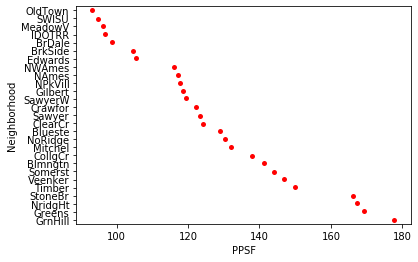

In [74]:
ames_engineered['PPSF'] = ames_engineered['SalePrice'] / ames_engineered['Gr_Liv_Area']

data = pd.concat([ames_engineered.groupby('Neighborhood').mean()['PPSF']], axis = 1)

f, ax = plt.subplots()

sns.stripplot(data.sort_values(by='PPSF').PPSF, data.sort_values(by='PPSF').index, orient='h', color='red');

In [75]:
# Number_of_Neighborhood_Clusters = 4

# hood_means = data.sort_values(by='PPSF').PPSF

# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=Number_of_Neighborhood_Clusters, random_state=42).fit(hood_means.values.reshape(-1, 1))

# hood_clusters = pd.concat([hood_means, pd.Series(kmeans.labels_, index=hood_means.index, name='Cluster')], axis = 1)

# def neighborhood_to_cluster(neigh_string):
#     return int(hood_clusters[ hood_clusters.index==neigh_string ]['Cluster'].values)

# ames_engineered['Neighborhood'] =  ames_engineered['Neighborhood'].apply(neighborhood_to_cluster)

# ppsf_dict = ames_engineered.groupby('Neighborhood_cluster')['PPSF'].agg('mean').to_dict()

# ames_engineered['N_PPSF'] = ames_engineered['Neighborhood_cluster'].map(ppsf_dict)

# ames_engineered['SP_Guess'] = ames_engineered['N_PPSF'] * ames_engineered['Gr_Liv_Area']


In [76]:
## Change Neighborhood to Neighborhood_Rank

ames_engineered['Avg_Psqft'] = ames_engineered['Neighborhood'].map(data.to_dict()['PPSF'])
# ames_engineered['AAvg_Psqft_Rank'] = ames_engineered['Avg_Psqft'].rank() 

# # high level - valuecounts by neighborhood and average price per sq ft by neighborhood
ames_nbhood_count = pd.DataFrame(ames_engineered['Neighborhood'].value_counts()).rename(columns = {'Neighborhood' : 'Nbhood_Count'})
ames_nbhood_stat = ames_engineered.groupby('Neighborhood').agg({'Gr_Liv_Area' : 'sum', 'SalePrice' : 'sum'})
ames_nbhood = pd.concat([ames_nbhood_count, ames_nbhood_stat], axis = 1)
ames_nbhood['Avg_Psqft'] = ames_nbhood['SalePrice'] /  ames_nbhood['Gr_Liv_Area']
ames_nbhood['Avg_Psqft_Rank'] = ames_nbhood['Avg_Psqft'].rank()

n_ppsf_rank = ames_nbhood[['Avg_Psqft_Rank']].to_dict()['Avg_Psqft_Rank']
ames_engineered['Neighborhood_Rank'] = ames_engineered['Neighborhood'].map(n_ppsf_rank)

ames_engineered.drop(['PPSF', 'Avg_Psqft', 'Neighborhood'], axis=1, inplace=True)


Apply neighborhood cluster update to Test set

In [77]:
Ames_test['Neighborhood_Rank'] = Ames_test['Neighborhood'].map(n_ppsf_rank)

Ames_test.drop('Neighborhood', axis=1, inplace=True)

## Feature Generation

In [78]:
ames_engineered['Neighborhood_Rank'] = ames_engineered['Neighborhood_Rank'] ** 0.5

Ames_test['Neighborhood_Rank'] = Ames_test['Neighborhood_Rank'] ** 0.5

ames_engineered['OQ_x_NR'] = ames_engineered['Overall_Qual'] * ames_engineered['Neighborhood_Rank']
Ames_test['OQ_x_NR'] = Ames_test['Overall_Qual'] * Ames_test['Neighborhood_Rank']

ames_engineered.drop(['Neighborhood_Rank', 'Overall_Qual'], axis=1, inplace=True)
Ames_test.drop(['Neighborhood_Rank', 'Overall_Qual'], axis=1, inplace=True)


## Remove Area features if using Total Area

In [79]:
# ames_engineered.drop(['Gr_Liv_Area', 'Total_Bsmt_SF', 'Garage_Area'], axis=1, inplace=True)
# Ames_test.drop(['Gr_Liv_Area', 'Total_Bsmt_SF', 'Garage_Area'], axis=1, inplace=True)

## Apply Regression Models

Reassign ames_engineered to Ames_train

In [80]:
Ames_train = ames_engineered.copy()

In [81]:
Ames_train_final = Ames_train.copy()
Ames_test_final = Ames_test.copy()

Ames_target_train_final = Ames_target_train.copy()
Ames_target_test_final = Ames_target_test.copy()

Ames_train_final = Ames_train.drop(['SalePrice'], axis=1)
Ames_test_final = Ames_test.drop(['SalePrice'], axis=1)

Ames_target_train_final = np.log(Ames_target_train_final)
Ames_target_test_final = np.log(Ames_target_test_final)


In [82]:
lasso = Lasso()
lasso.set_params(alpha=0, normalize=True, max_iter=2000)
lasso.fit(Ames_train_final, Ames_target_train_final) # fit data
print("The determination of lasso regression is: %.4f" %lasso.score(Ames_train_final, Ames_target_train_final))

The determination of lasso regression is: 0.9489


In [83]:
coefs = []
intercepts = []
R2 = []
alpharange = np.linspace(0, 500, 20)
for alpha in alpharange:
    lasso.set_params(alpha=alpha, normalize=True, max_iter=2000)
    lasso.fit(Ames_train_final, Ames_target_train_final)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    R2.append(lasso.score(Ames_train_final, Ames_target_train_final))

Text(0.5, 1.0, 'Change of Ridge Slopes Varying Alpha')

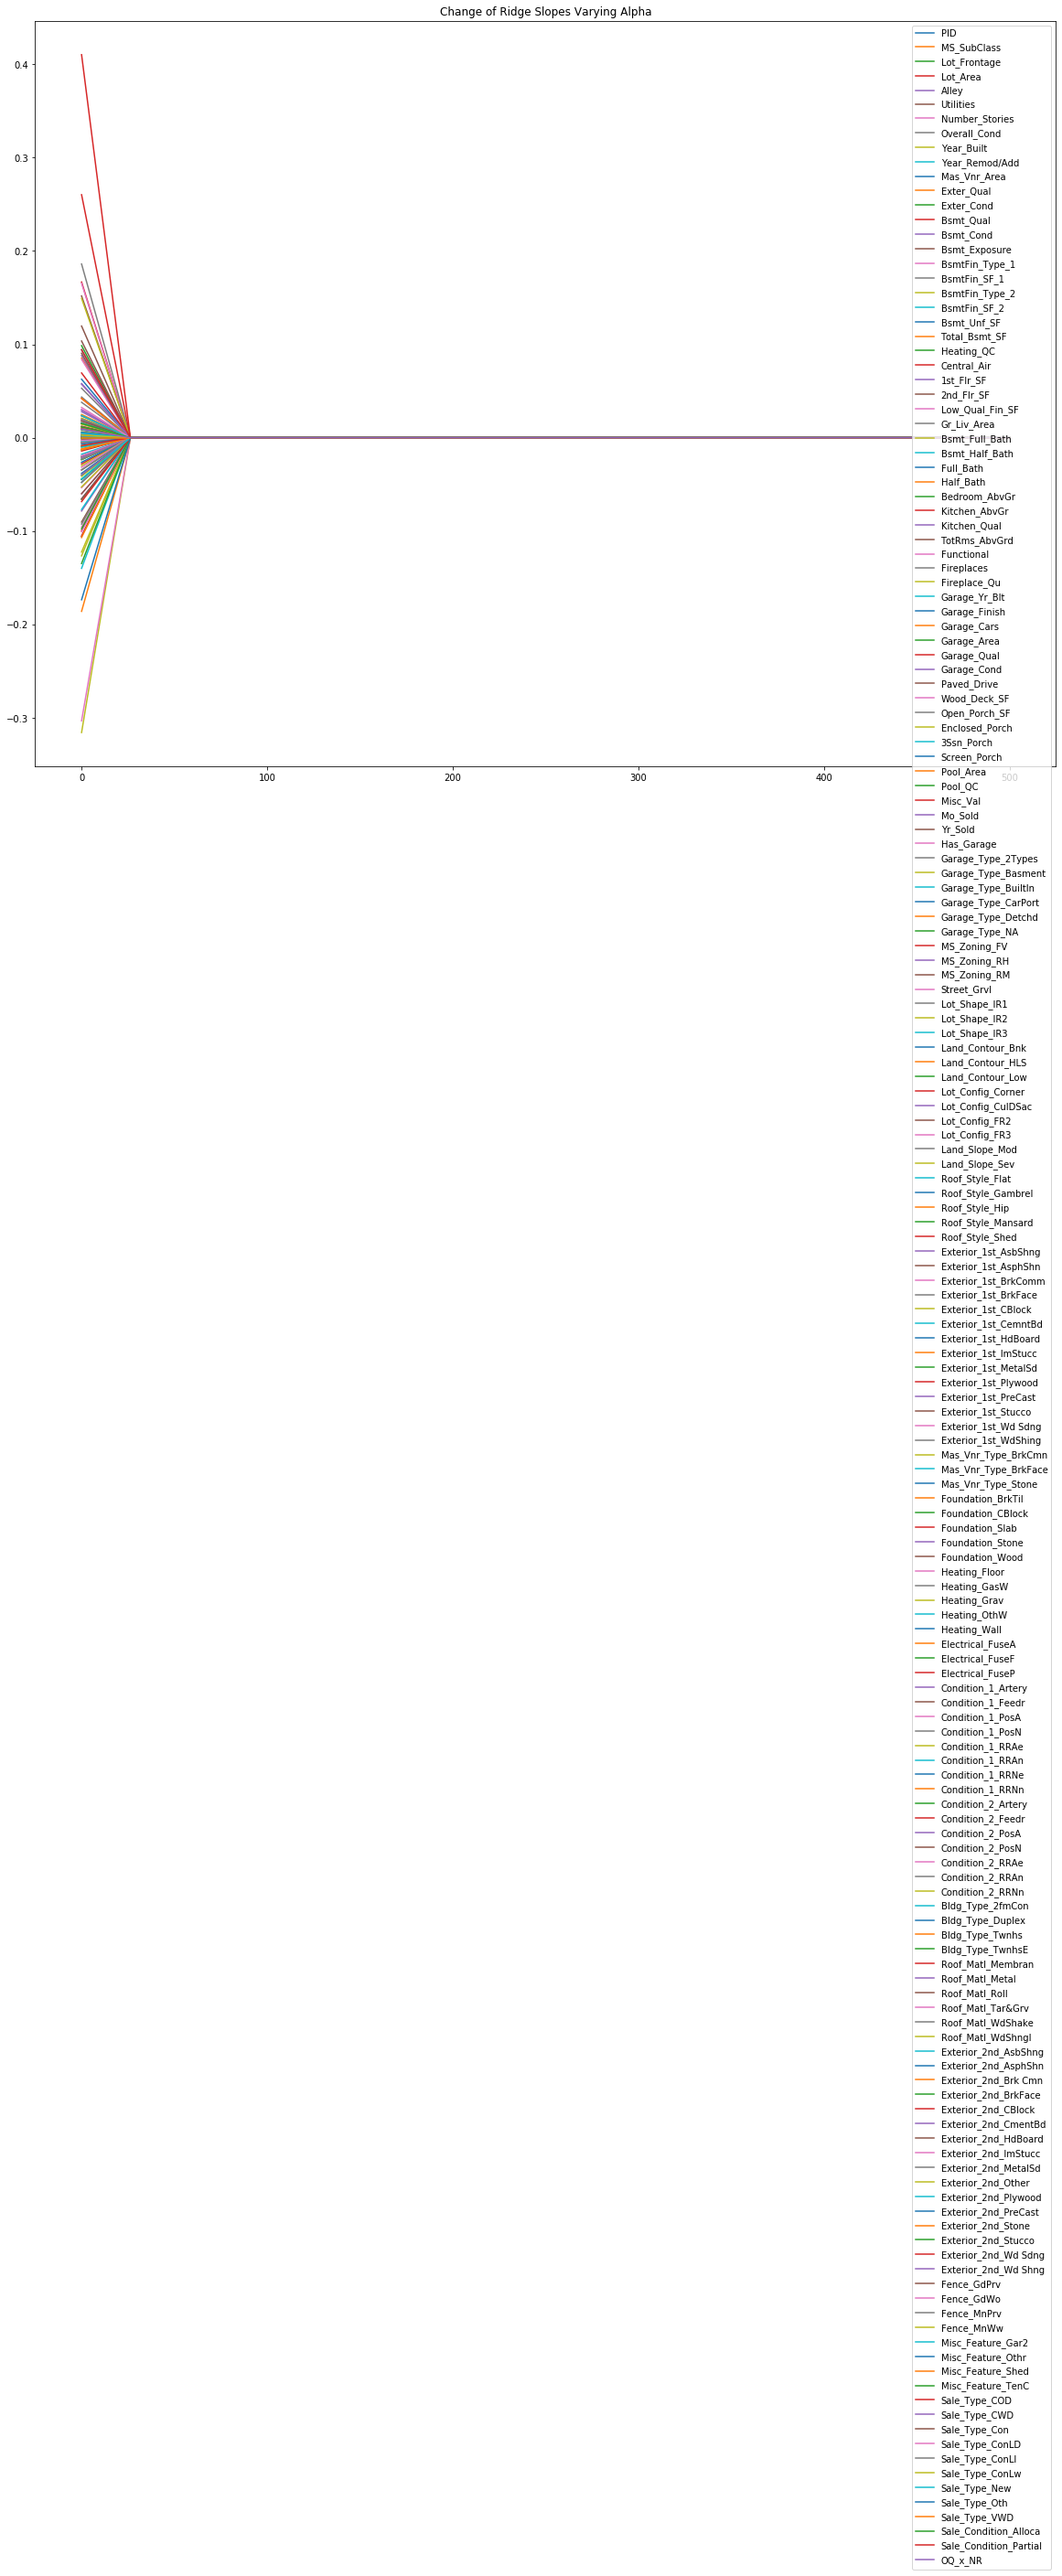

In [84]:
coefs = pd.DataFrame(np.array(coefs), columns=Ames_train_final.columns)
plt.figure(figsize=(20,15)) 

for name in coefs.columns:
    plt.plot(alpharange, coefs[name], label=name)
   
plt.legend(loc=1)    
plt.title('Change of Ridge Slopes Varying Alpha')



In [85]:
train_R2 = []
test_R2  = []
alphaRange = np.linspace(0,500,20)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=True, max_iter=2000)  
    lasso.fit(Ames_train_final, Ames_target_train_final)
    train_R2.append(lasso.score(Ames_train_final, Ames_target_train_final))
    test_R2.append(lasso.score(Ames_test_final, Ames_target_test_final))

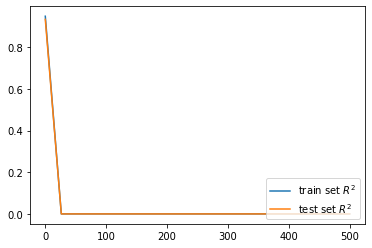

In [86]:
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

In [87]:
lasso.set_params(alpha=0, normalize=True, max_iter=2000)  
lasso.fit(Ames_train_final, Ames_target_train_final)

# yhat = lasso.predict(Ames_test)
# SS_Residual = sum((Ames_target_test-yhat)**2)       
# SS_Total = sum((Ames_target_test-np.mean(Ames_target_test))**2)     
# r_squared = 1 - (float(SS_Residual))/SS_Total
# adjusted_r_squared = 1 - (1-r_squared)*(len(Ames_target_test)-1)/(len(Ames_target_test)-Ames_test.shape[1]-1)

print(lasso.score(Ames_train_final, Ames_target_train_final))
print(lasso.score(Ames_test_final, Ames_target_test_final))

0.9489248140822533
0.933755085052234


In [88]:
lasso.set_params(alpha=0, normalize=True)
lasso.fit(Ames_train_final, Ames_target_train_final)
print('The intercept is %.4f' %(lasso.intercept_))
lassoCoef = pd.Series(lasso.coef_, index=Ames_train_final.columns)
print('The slopes are %s' %(lassoCoef))

The intercept is 9.5013
The slopes are PID                      -5.101876e-11
MS_SubClass              -8.774897e-05
Lot_Frontage              3.095749e-04
Lot_Area                  2.224289e-06
Alley                     3.503093e-04
                              ...     
Sale_Type_Oth            -1.735028e-01
Sale_Type_VWD             0.000000e+00
Sale_Condition_Alloca     1.527347e-02
Sale_Condition_Partial    9.429564e-02
OQ_x_NR                   9.219514e-03
Length: 175, dtype: float64


In [89]:
sortedCoefs = np.abs(lassoCoef).sort_values(ascending=False)
sortedCoefs.head(10)

Roof_Matl_Membran       0.410144
Exterior_1st_CBlock     0.315676
Condition_2_RRAe        0.303127
Exterior_2nd_CBlock     0.260210
Exterior_1st_BrkFace    0.186009
Exterior_2nd_Stone      0.185900
Sale_Type_Oth           0.173503
Roof_Style_Shed         0.166723
Exterior_1st_BrkComm    0.165378
Utilities               0.151821
dtype: float64

In [90]:
sortedCoefs = np.abs(lassoCoef).sort_values(ascending=False)
sortedCoefs_df = pd.DataFrame(sortedCoefs)
remaining_coefs = list(sortedCoefs_df.loc[sortedCoefs_df[0] != 0,].index)
Ames_train_final[remaining_coefs]

,Roof_Matl_Membran,Exterior_1st_CBlock,Condition_2_RRAe,Exterior_2nd_CBlock,Exterior_1st_BrkFace,Exterior_2nd_Stone,Sale_Type_Oth,Roof_Style_Shed,Exterior_1st_BrkComm,Utilities,...,Garage_Area,Bsmt_Unf_SF,Gr_Liv_Area,Total_Bsmt_SF,Wood_Deck_SF,Mas_Vnr_Area,Pool_Area,Misc_Val,Lot_Area,PID
Order,,,,,,,,,,,,,,,,,,,,,
240,0,0,0,0,0,0,0,0,0,3.0,...,366.0,218.0,1172,1172.0,240,0.0,0,0,9525,905452160
15,0,0,0,0,0,0,0,0,0,3.0,...,528.0,0.0,1502,1488.0,0,0.0,0,0,6820,527182190
1281,0,0,0,0,0,0,0,0,0,3.0,...,483.0,380.0,1796,780.0,0,415.0,0,0,7056,535475020
2450,0,0,0,0,0,0,0,0,0,3.0,...,725.0,815.0,2726,1342.0,307,397.0,0,0,10019,528358030
128,0,0,0,0,0,0,0,0,0,3.0,...,400.0,470.0,2461,1140.0,0,265.0,0,0,9724,534431050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,0,0,0,0,0,0,0,0,0,3.0,...,372.0,732.0,1838,732.0,100,0.0,0,0,21930,528231050
1603,0,0,0,0,0,0,0,0,0,3.0,...,264.0,282.0,816,816.0,315,0.0,0,0,6490,923252100
203,0,0,0,0,0,0,0,0,0,3.0,...,572.0,888.0,1962,888.0,160,0.0,0,0,8094,903426180


In [91]:
from sklearn.model_selection import GridSearchCV, KFold

params_lasso = [ {'alpha':[0, 1, 10, 50, 100, 150, 200, 250]} ]

kf5 = KFold(n_splits = 5, shuffle = True)

grid_lasso = GridSearchCV(estimator = lasso, param_grid = params_lasso, cv = 5)

grid_lasso.fit(Ames_train_final, Ames_target_train_final)

print(f'Best Lasso Score: {grid_lasso.best_score_}')


Best Lasso Score: 0.9229462235994145


In [92]:
best_model = grid_lasso.best_estimator_

In [93]:
best_model.score(Ames_test_final, Ames_target_test_final)

0.933755085052234

In [94]:
best_model

Lasso(alpha=0, max_iter=2000, normalize=True)

In [95]:
grid_lasso.best_params_

{'alpha': 0}

In [96]:
print('The intercept is %.4f' %(best_model.intercept_))
lassoCoef = pd.Series(best_model.coef_, index=Ames_test_final.columns)
print('The slopes are %s' %(lassoCoef))

The intercept is 9.5013
The slopes are PID                      -5.101876e-11
MS_SubClass              -8.774897e-05
Lot_Frontage              3.095749e-04
Lot_Area                  2.224289e-06
Alley                     3.503093e-04
                              ...     
Sale_Type_Oth            -1.735028e-01
Sale_Type_VWD             0.000000e+00
Sale_Condition_Alloca     1.527347e-02
Sale_Condition_Partial    9.429564e-02
OQ_x_NR                   9.219514e-03
Length: 175, dtype: float64


In [97]:
sortedCoefs = np.abs(lassoCoef).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0]

Roof_Matl_Membran       4.101436e-01
Exterior_1st_CBlock     3.156755e-01
Condition_2_RRAe        3.031270e-01
Exterior_2nd_CBlock     2.602097e-01
Exterior_1st_BrkFace    1.860086e-01
                            ...     
Mas_Vnr_Area            2.060944e-05
Pool_Area               1.493442e-05
Misc_Val                4.951746e-06
Lot_Area                2.224289e-06
PID                     5.101876e-11
Length: 169, dtype: float64